In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
!pip install lib/kaggle-rig-0.2.0.tar.gz
import krig
krig.seed_everything()

Processing ./lib/kaggle-rig-0.2.0.tar.gz
  Created wheel for kaggle-rig: filename=kaggle_rig-0.2.0-py3-none-any.whl size=6539 sha256=eecf3303b67c2095d699e75b11aa6e4c48ff98d46ac8ccf0d899cc4ee3df2745
  Stored in directory: /home/pankun/.cache/pip/wheels/03/99/72/07676e0abd65551d5261aee9360ad1c85fcaca1c409857a40a
Successfully built kaggle-rig
  Attempting uninstall: kaggle-rig
    Found existing installation: kaggle-rig 0.2.0
    Uninstalling kaggle-rig-0.2.0:
      Successfully uninstalled kaggle-rig-0.2.0


In [3]:
FOLDS = 10
ESTIMATORS = 2000
DATA = 'input/processed'
TARGET = ['fvc_last_3', 'fvc_last_2', 'fvc_last_1']
NON_FEATURES = set(TARGET) | {'pid', 'week_last_1', 'week_last_2', 'week_last_3'}
CATEGORICALS = {'sex', 'smoking'}
SCORING = 'neg_root_mean_squared_error'

In [4]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [5]:
train = pd.read_parquet(f'{DATA}/cvtrain.parquet')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pid                    174 non-null    object 
 1   age                    174 non-null    uint8  
 2   sex                    174 non-null    object 
 3   smoking                174 non-null    object 
 4   week_1                 174 non-null    int16  
 5   fvc_1                  174 non-null    uint16 
 6   percent_1              174 non-null    float32
 7   fvc_last_1             174 non-null    uint16 
 8   fvc_last_2             174 non-null    uint16 
 9   fvc_last_3             174 non-null    uint16 
 10  week_last_1            174 non-null    int16  
 11  week_last_2            174 non-null    int16  
 12  week_last_3            174 non-null    int16  
 13  fvc_last_1_min         174 non-null    float32
 14  fvc_last_1_p50         174 non-null    float32
 15  fvc_la

In [6]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,fvc_last_1_min,fvc_last_1_p50,fvc_last_1_p75,fvc_last_1_p90,fvc_last_1_p95,fvc_last_1_p99,fvc_last_1_max,fvc_last_2_min,fvc_last_2_p50,fvc_last_2_p75,fvc_last_2_p90,fvc_last_2_p95,fvc_last_2_p99,fvc_last_2_max,fvc_last_3_min,fvc_last_3_p50,fvc_last_3_p75,fvc_last_3_p90,fvc_last_3_p95,fvc_last_3_p99,fvc_last_3_max,lung_area_min,lung_area_p50,lung_area_p75,lung_area_p90,lung_area_p95,lung_area_p99,lung_area_max,tissue_area_min,tissue_area_p50,tissue_area_p75,tissue_area_p90,tissue_area_p95,tissue_area_p99,tissue_area_max,lung_tissue_ratio_min,lung_tissue_ratio_p50,lung_tissue_ratio_p75,lung_tissue_ratio_p90,lung_tissue_ratio_p95,lung_tissue_ratio_p99,lung_tissue_ratio_max
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,1920.955200,2081.254150,2120.071289,2184.236328,2221.485840,2286.175293,2306.677490,1917.523438,2077.789551,2116.439697,2181.167725,2218.072510,2282.713379,2303.235352,1919.379639,2079.752930,2118.514648,2182.974121,2220.087646,2284.790771,2305.311035,670.0,1656.0,2391.25,2693.100098,2721.350098,2828.399902,2869.0,4255.0,6106.0,9372.75,11325.299805,12560.299805,13245.419922,13333.0,0.059491,0.256664,0.446996,0.568525,0.573278,0.626535,0.647630
1,ID00009637202177434476278,69,Male,Ex-smoker,8,3660,85.282875,3214,3390,3625,60,45,33,2196.767578,2469.969727,2512.368408,2542.463867,2562.051270,2597.386719,2630.166992,2192.734375,2465.634277,2508.892090,2538.629883,2558.251709,2593.677002,2625.989258,2195.318604,2468.214600,2511.116211,2541.058350,2560.650146,2596.082520,2628.625244,704.0,2156.5,2867.00,3206.899902,3339.449951,3478.419922,3523.0,9535.0,11885.5,16274.00,18535.300781,19007.099609,19512.429688,19734.0,0.039308,0.198787,0.255620,0.288663,0.300436,0.322504,0.335254
2,ID00010637202177584971671,60,Male,Ex-smoker,0,3523,94.724670,2518,2474,2993,54,37,25,1868.998901,2040.578613,2107.123291,2156.577148,2200.287109,2249.202881,2249.753906,1864.390503,2036.863037,2103.311768,2153.071777,2196.638672,2245.308838,2246.365723,1867.094849,2039.142090,2105.668213,2155.200439,2198.871094,2247.746826,2248.618408,232.0,1288.5,2612.75,3364.000000,3721.250000,4241.149902,4315.0,6774.0,10859.0,12289.00,15495.000000,16202.750000,16849.349609,16897.0,0.013873,0.115833,0.317440,0.443931,0.488324,0.562757,0.585732
3,ID00012637202177665765362,65,Male,Never smoked,33,3418,93.726006,2971,3231,3324,87,71,58,1951.035522,2218.250977,2431.690674,2504.411865,2548.026367,2585.155029,2604.155518,1947.046143,2214.118164,2427.277588,2500.539795,2543.887207,2580.864746,2600.005371,1949.461792,2216.648926,2430.060059,2503.040283,2546.532227,2583.598877,2602.641113,204.0,1129.0,1826.00,2223.399902,2491.600098,2976.679932,3089.0,5799.0,7015.0,8992.00,10425.000000,10657.200195,11110.839844,11371.0,0.024120,0.147254,0.295255,0.343806,0.391733,0.479589,0.516469
4,ID00014637202177757139317,56,Male,Ex-smoker,0,3807,90.076660,3027,3439,3221,54,37,26,1830.547729,2233.393799,2346.294922,2408.884277,2432.954102,2462.016357,2472.381836,1825.554688,2228.799805,2341.391846,2403.918213,2428.371094,2457.094238,2467.383545,1828.722656,2231.830566,2344.479492,2407.093262,2431.290283,2460.188965,2470.538818,516.0,1537.0,2958.50,3736.000000,4082.000000,5042.600098,5360.0,7745.0,10419.0,13426.50,17834.000000,18872.000000,19514.500000,19651.0,0.028359,0.143710,0.316701,0.432157,0.452699,0.625855,0.692059


In [7]:
def encode(df, col, encoder) -> None:
    df[col] = df[col].map(encoder).fillna(0)
    assert not df[col].isna().any()

 
for col in CATEGORICALS:
    encoder = dict(train[col].value_counts(normalize=True))
    print(f'col={col}, encoder={encoder}')
    encode(train, col, encoder)

col=smoking, encoder={'Ex-smoker': 0.6666666666666666, 'Never smoked': 0.28160919540229884, 'Currently smokes': 0.05172413793103448}
col=sex, encoder={'Male': 0.7873563218390804, 'Female': 0.21264367816091953}


In [8]:
FEATURES = set(train.columns) - NON_FEATURES
FEATURES = list(FEATURES)
FEATURES.sort()
print(f'{len(FEATURES)} FEATURES={FEATURES}')

48 FEATURES=['age', 'fvc_1', 'fvc_last_1_max', 'fvc_last_1_min', 'fvc_last_1_p50', 'fvc_last_1_p75', 'fvc_last_1_p90', 'fvc_last_1_p95', 'fvc_last_1_p99', 'fvc_last_2_max', 'fvc_last_2_min', 'fvc_last_2_p50', 'fvc_last_2_p75', 'fvc_last_2_p90', 'fvc_last_2_p95', 'fvc_last_2_p99', 'fvc_last_3_max', 'fvc_last_3_min', 'fvc_last_3_p50', 'fvc_last_3_p75', 'fvc_last_3_p90', 'fvc_last_3_p95', 'fvc_last_3_p99', 'lung_area_max', 'lung_area_min', 'lung_area_p50', 'lung_area_p75', 'lung_area_p90', 'lung_area_p95', 'lung_area_p99', 'lung_tissue_ratio_max', 'lung_tissue_ratio_min', 'lung_tissue_ratio_p50', 'lung_tissue_ratio_p75', 'lung_tissue_ratio_p90', 'lung_tissue_ratio_p95', 'lung_tissue_ratio_p99', 'percent_1', 'sex', 'smoking', 'tissue_area_max', 'tissue_area_min', 'tissue_area_p50', 'tissue_area_p75', 'tissue_area_p90', 'tissue_area_p95', 'tissue_area_p99', 'week_1']


In [9]:
x_train = train[FEATURES]

In [10]:
%%time
models = []
results = []


for col in TARGET:
    y_train = train[col]
    model = lgb.LGBMRegressor(n_estimators=ESTIMATORS, reg_alpha=1)
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__learning_rate': [0.01, 0.001],
        'model__subsample': [0.01, 0.05, 0.1],
        'model__min_child_samples': [20],
        'model__colsample_bytree': [0.2]
    }
    lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
    lgbm.fit(x_train, y_train)
    best_score = lgbm.best_score_
    best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
    print(f"""LGBM y={col}
best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
    """)
    res = pd.DataFrame.from_dict(lgbm.cv_results_)
    res.set_index('rank_test_score', inplace=True)
    res.sort_index(inplace=True)
    models.append(lgbm)
    results.append(res)

LGBM y=fvc_last_3
best params={'model__colsample_bytree': 0.2, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
best score=-373.411, std=56.861
    
LGBM y=fvc_last_2
best params={'model__colsample_bytree': 0.2, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
best score=-417.165, std=51.158
    
LGBM y=fvc_last_1
best params={'model__colsample_bytree': 0.2, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
best score=-419.103, std=62.948
    
CPU times: user 4min 2s, sys: 5.42 s, total: 4min 7s
Wall time: 42.2 s


In [11]:
results[0].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.238020,0.029935,0.002133,0.000227,0.2,0.01,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-423.978755,-347.449663,-348.318114,-368.518069,-376.874208,-481.748591,-366.273599,-246.007790,-384.316753,-390.624737,-373.411028,56.860776
1,0.223136,0.010791,0.002026,0.000090,0.2,0.01,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-423.978755,-347.449663,-348.318114,-368.518069,-376.874208,-481.748591,-366.273599,-246.007790,-384.316753,-390.624737,-373.411028,56.860776
1,0.221695,0.010182,0.002071,0.000119,0.2,0.01,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-423.978755,-347.449663,-348.318114,-368.518069,-376.874208,-481.748591,-366.273599,-246.007790,-384.316753,-390.624737,-373.411028,56.860776
4,0.233077,0.016918,0.002144,0.000252,0.2,0.001,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-451.811397,-449.594623,-485.595306,-495.011739,-435.840706,-687.388421,-558.645431,-435.970823,-533.463217,-489.353203,-502.267487,72.833238
4,0.250042,0.018941,0.002108,0.000203,0.2,0.001,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-451.811397,-449.594623,-485.595306,-495.011739,-435.840706,-687.388421,-558.645431,-435.970823,-533.463217,-489.353203,-502.267487,72.833238
4,0.227405,0.017582,0.002073,0.000145,0.2,0.001,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-451.811397,-449.594623,-485.595306,-495.011739,-435.840706,-687.388421,-558.645431,-435.970823,-533.463217,-489.353203,-502.267487,72.833238


In [12]:
results[1].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.259666,0.051697,0.004516,0.006740,0.2,0.01,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-418.595274,-431.368784,-375.145818,-353.112182,-474.205048,-526.205859,-432.720865,-365.929542,-422.583583,-371.779957,-417.164691,51.158445
1,0.224588,0.006112,0.002098,0.000129,0.2,0.01,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-418.595274,-431.368784,-375.145818,-353.112182,-474.205048,-526.205859,-432.720865,-365.929542,-422.583583,-371.779957,-417.164691,51.158445
1,0.222572,0.001678,0.002035,0.000046,0.2,0.01,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-418.595274,-431.368784,-375.145818,-353.112182,-474.205048,-526.205859,-432.720865,-365.929542,-422.583583,-371.779957,-417.164691,51.158445
4,0.218085,0.007046,0.002046,0.000075,0.2,0.001,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-516.434878,-517.908926,-476.091963,-494.252138,-468.185892,-752.585970,-566.673538,-529.412910,-542.980172,-472.434109,-533.696050,79.101639
4,0.217555,0.004194,0.002071,0.000100,0.2,0.001,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-516.434878,-517.908926,-476.091963,-494.252138,-468.185892,-752.585970,-566.673538,-529.412910,-542.980172,-472.434109,-533.696050,79.101639
4,0.216038,0.005032,0.002044,0.000123,0.2,0.001,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-516.434878,-517.908926,-476.091963,-494.252138,-468.185892,-752.585970,-566.673538,-529.412910,-542.980172,-472.434109,-533.696050,79.101639


In [13]:
results[2].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.224428,0.008166,0.002663,0.001815,0.2,0.01,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-429.572157,-443.674968,-373.981880,-391.220239,-479.430535,-512.935677,-343.734116,-302.286274,-483.929025,-430.269750,-419.103462,62.947961
1,0.220385,0.003526,0.002057,0.000050,0.2,0.01,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-429.572157,-443.674968,-373.981880,-391.220239,-479.430535,-512.935677,-343.734116,-302.286274,-483.929025,-430.269750,-419.103462,62.947961
1,0.220699,0.002646,0.002383,0.000965,0.2,0.01,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-429.572157,-443.674968,-373.981880,-391.220239,-479.430535,-512.935677,-343.734116,-302.286274,-483.929025,-430.269750,-419.103462,62.947961
4,0.215684,0.003427,0.002071,0.000128,0.2,0.001,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-351.120384,-586.711895,-522.407145,-463.596501,-534.673830,-739.153631,-503.527764,-490.151061,-574.373870,-523.881784,-528.959786,93.665729
4,0.215234,0.004066,0.002049,0.000033,0.2,0.001,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-351.120384,-586.711895,-522.407145,-463.596501,-534.673830,-739.153631,-503.527764,-490.151061,-574.373870,-523.881784,-528.959786,93.665729
4,0.218315,0.006642,0.002056,0.000090,0.2,0.001,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-351.120384,-586.711895,-522.407145,-463.596501,-534.673830,-739.153631,-503.527764,-490.151061,-574.373870,-523.881784,-528.959786,93.665729


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

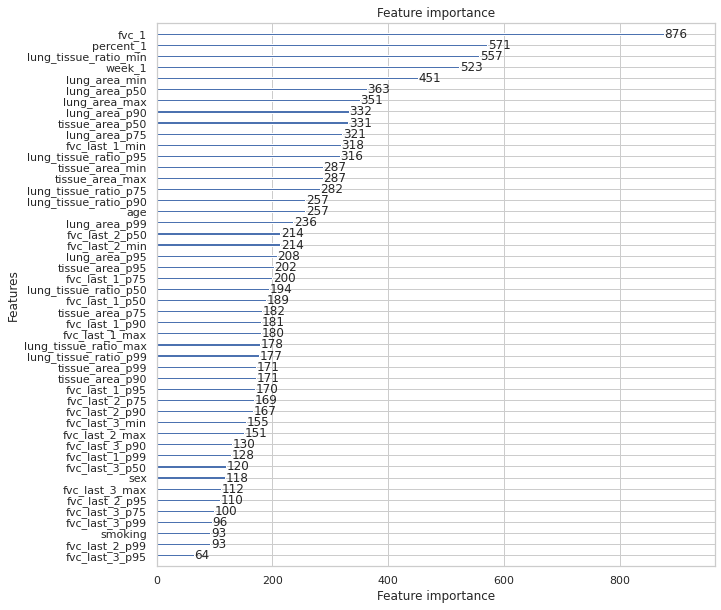

In [14]:
lgb.plot_importance(models[0].best_estimator_['model'], figsize=(10, 10))
    

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

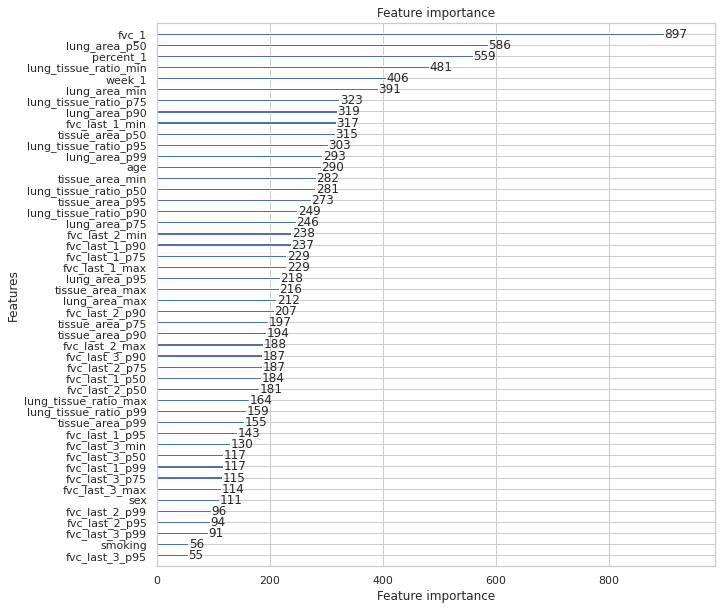

In [15]:
lgb.plot_importance(models[1].best_estimator_['model'], figsize=(10, 10))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

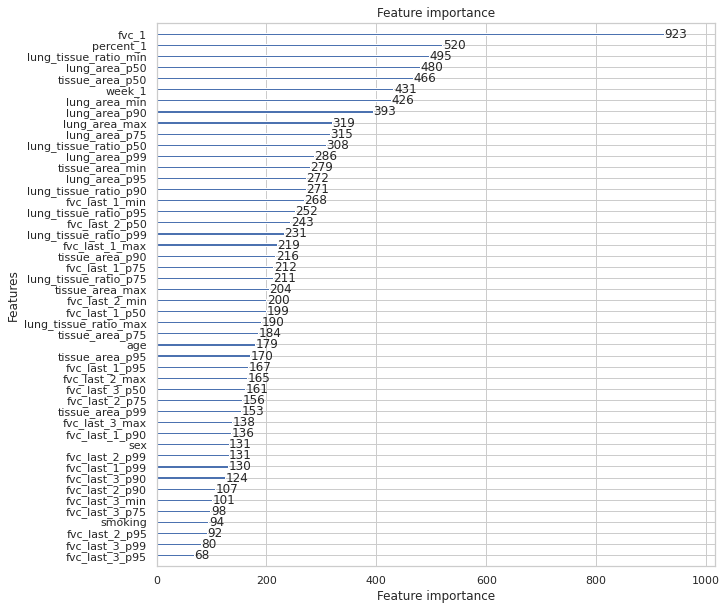

In [16]:
lgb.plot_importance(models[2].best_estimator_['model'], figsize=(10, 10))

In [17]:
for i in range(len(models)):
    y = TARGET[i]
    lgbm = models[i]
    lgbm.best_estimator_['model'].booster_.save_model(f'output/lgb_{y}.txt')